# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [113]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

# To process large dataset
import dask
import dask.dataframe as dd

from collections import Counter
from operator import itemgetter

# To check performance of the operation
import time

from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load Data
Since the dataset is more than 1GB, I've used `c` engine instead of `python` to load data faster. In addition, there are mixed data in column 18 & 19; more specifically some `NaN` values are represented by `X` & `XX`. These values are set as `na_values`.

In [2]:
def load_data(azdias_filepath, customers_filepath, attributes_filepath):
    """
    Method for loading dataset from CSV & Excel
    
    Args:
        azdias_filepath (str): Azdias Filepath
        customers_filepath (str): Customers Filepath
        attributes_filepath (str): Attributes Filepath
        
    Output:
        azdias: Pandas Dataframe
        customers: Pandas Dataframe
        attributes: Pandas Dataframe
    """
    
    # Load "azdias" dataset
    azdias = pd.read_csv(azdias_filepath, na_values=["X", "XX"], engine="c")
    
    # Load "customers" dataset
    customers = pd.read_csv(customers_filepath, na_values=["X", "XX"], engine="c")
    
    # Load "attributes" dataset
    attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1).loc[:, ["Attribute", "Value", "Meaning"]] \
                                .fillna(method='ffill')
    
    return azdias, customers, attributes

In [3]:
azdias_filepath = "Udacity_AZDIAS_052018.csv"
customers_filepath = "Udacity_CUSTOMERS_052018.csv"
attributes_filepath = "DIAS Attributes - Values 2017.xlsx"

azdias, customers, attributes = load_data(azdias_filepath, customers_filepath, attributes_filepath)

### Data Exploration (azdias)
Explore `azdias` dataset to gain insights about the type of data, extent of data cleaning and feature engineering

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
attributes.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly


In [6]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      floa

In [7]:
# List of unique features in different dataset
attribute_list = list(attributes.Attribute.unique())
azdias_features = azdias.columns.tolist()

# Find common and unique features between 'azdias' and 'attributes'
common_features = set(azdias_features) & set(attribute_list)
unique_azdias_features = set(azdias_features) - set(attribute_list)
num_common_features = len(common_features)
num_unique_azdias_features = len(unique_azdias_features)
print("common features: {}, unique azdias features: {}".format(num_common_features, num_unique_azdias_features))

common features: 272, unique azdias features: 94


**Observations:** Since 94 features in `azdias` do not have any descriptions in `attributes`, these features will be dropped. In addition, some features in `attributes` have values assigned to _unknown_ or _missing information._ These values in `azdias` will be replaced with `NaN`.

In [8]:
azdias.drop(columns=list(unique_azdias_features), inplace=True)

In [9]:
azdias.shape

(891221, 272)

In [10]:
# Create a subset of "attributes" where only unknown values are present
attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | attributes['Meaning'].str.contains("no "))]

unknown_val = []
for attribute in attributes_unknown_val['Attribute'].unique():
    # Create a list of unknown value for a feature
    val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str").str.cat(sep=',').split(',')
    # Convert the list to "int"
    val = list(map(int, val))
    unknown_val.append(val)
    
# Create dataframe of features with unknown value
attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                    pd.Series(unknown_val)], axis=1)

# Rename the columns
attributes_unknown_val.columns = ['attribute', 'unknown']

attributes_unknown_val.head()

,attribute,unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [11]:
# Replace the unknown values in "azdias" with NaN based on "attributes_unknown_val" 
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in azdias.columns.values.tolist():
        print(row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        nan_idx = azdias.loc[:, row.attribute].isin(nan_val)
        azdias.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue
        
azdias.head()

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA0

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,...,1.0,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,...,4.0,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,...,4.0,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,...,7.0,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


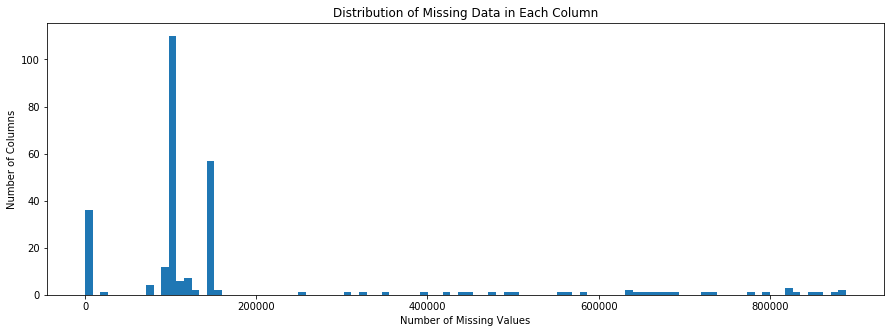

In [12]:
# Check the total number of NaN count on each column
nan_count_column_azdias = azdias.isnull().sum()

# Plot the distribution of missing or unknown data for each column
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Column')
plt.hist(nan_count_column_azdias, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [13]:
# Drop the columns where the NaN count is higher than 20000 i.e. more than 20%
# Select the columns that are needed to be dropped
drop_columns = nan_count_column_azdias[nan_count_column_azdias > 200000]

# Make list of the drop_columns
drop_column_list = drop_columns.index.tolist()

# Drop the columns from azdias
azdias.drop(columns=drop_column_list, inplace=True)

azdias.shape

(891221, 237)

In [14]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0,...,3.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0


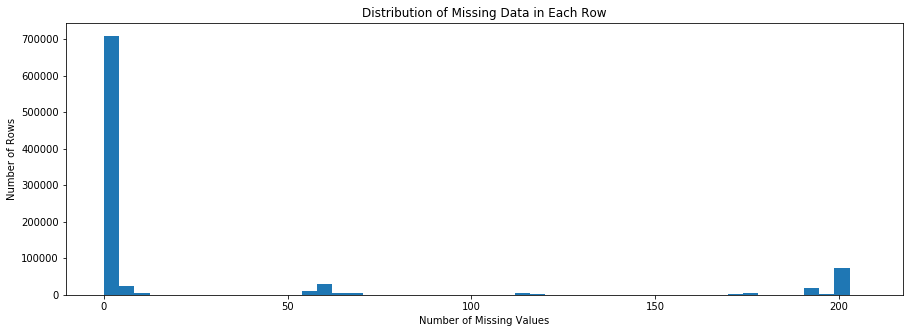

In [15]:
# Similar to columns, check the total NaN count for each row
count_nan_row = azdias.isnull().sum(axis=1)
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Row')
plt.hist(count_nan_row, bins=50)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [16]:
# # Drop the rows where the NaN count is higher than 50 i.e. more than 20%
count_nan_row = azdias.shape[1] - azdias.count(axis=1)
drop_row = azdias.index[count_nan_row > 50]
azdias.drop(drop_row, axis=0, inplace=True)

In [17]:
print(azdias.shape)
azdias.head()

(737288, 237)


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0
5,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,2.0,2.0,...,6.0,2.0,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0


### Create function for cleaning the dataset

In [18]:
def clean_data(df, attributes, col_nan_threshold, row_nan_threshold):
    """
    Method for cleaning the dataset according to attributes
    
    Args:
        df (Pandas Dataframe): Dataset to clean
        attributes (Pandas Dataframe): Reference dataset for cleaning df
        col_nan_threshold (float): Threshold value (0-1) for missing NaN count in a column
        row_nan_threshold (float): Threshold value (0-1) for missing NaN count in a row
        
    Output:
        df (Pandas Dataframe): Cleaned dataset
    """
    
    # List of attributes
    attribute_list = list(attributes.Attribute.unique())
    
    # List of df attributes
    df_attributes = list(df.columns)
    
    # Find attributes that are unique in df
    unique_df_attributes = list(set(df_attributes) - set(attribute_list))    
    
    # Drop attributes from df that are not present in attribute
    df.drop(columns=unique_df_attributes, inplace=True)
    
    # Create a subset of attributes with unknown or no information value
    unknown_val = []
    attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | 
                                         attributes['Meaning'].str.contains("no "))]
    for attribute in attributes_unknown_val['Attribute'].unique():
        val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str") \
                                                                            .str.cat(sep=',').split(',')
        val = list(map(int, val))
        unknown_val.append(val)
    attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                        pd.Series(unknown_val)], axis=1)
    attributes_unknown_val.columns = ['attribute', 'unknown']
    
    # Replace unknown or missing values in df with NaN   
    for row in attributes_unknown_val.itertuples(index=False):
        if row.attribute in df.columns.values.tolist():
            nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
            nan_idx = df.loc[:, row.attribute].isin(nan_val)
            df.loc[nan_idx, row.attribute] = np.NaN
        else:
            continue
    
    # Drop columns where NaN count is above the threshold
    nan_count_column = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    # Select the columns that are needed to be dropped
    nan_count_column = nan_count_column[nan_count_column > col_nan_threshold]
    # Make list of the drop_columns
    drop_column_list = nan_count_column.index.tolist()
    # Drop the columns from azdias
    df.drop(columns=drop_column_list, inplace=True)
    
    # Dropping rows where NaN count is above the threshold
    number_col = df.shape[1]
    count_nan_row = (df.shape[1] - df.count(axis=1)) / number_col
    drop_row = df.index[count_nan_row > row_nan_threshold]
    df.drop(drop_row, axis=0, inplace=True)
    
    return df

In [19]:
customers = clean_data(customers, attributes, 0.2, 0.2)
customers.shape

(188439, 37)

In [20]:
customers.head(20)

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,5.0,1.0,2.0,5.0,1.0,2.0,5.0,2.0,0,4.0,...,6.0,2.0,1.0,2.0,6.0,1.0,6.0,3.0,1.0,4.0
2,2.0,1.0,4.0,5.0,1.0,4.0,5.0,2.0,0,3.0,...,3.0,4.0,2.0,1.0,2.0,1.0,3.0,3.0,2.0,4.0
3,2.0,2.0,2.0,5.0,1.0,1.0,5.0,6.0,0,10.0,...,4.0,3.0,3.0,3.0,6.0,4.0,7.0,1.0,1.0,4.0
4,6.0,4.0,2.0,3.0,1.0,5.0,4.0,2.0,1960,2.0,...,6.0,5.0,5.0,4.0,4.0,4.0,5.0,1.0,1.0,3.0
5,4.0,1.0,3.0,5.0,1.0,2.0,5.0,5.0,0,11.0,...,1.0,3.0,2.0,4.0,6.0,4.0,7.0,2.0,1.0,3.0
6,2.0,1.0,2.0,5.0,1.0,1.0,5.0,2.0,1942,10.0,...,1.0,2.0,3.0,5.0,4.0,4.0,6.0,1.0,1.0,4.0
7,2.0,1.0,2.0,5.0,1.0,2.0,5.0,5.0,1938,8.0,...,6.0,1.0,1.0,5.0,6.0,1.0,7.0,3.0,1.0,4.0
8,1.0,1.0,5.0,2.0,2.0,1.0,5.0,5.0,1914,3.0,...,1.0,1.0,3.0,1.0,2.0,1.0,2.0,3.0,2.0,4.0
9,3.0,1.0,1.0,5.0,2.0,3.0,4.0,2.0,1959,1.0,...,1.0,3.0,2.0,4.0,6.0,4.0,7.0,1.0,1.0,3.0
10,5.0,4.0,1.0,4.0,2.0,3.0,4.0,6.0,1960,11.0,...,2.0,4.0,4.0,1.0,4.0,3.0,4.0,3.0,2.0,3.0


In [21]:
azdias.head(20)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,3.0,5.0,...,6.0,1.0,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,4.0,2.0,...,3.0,4.0,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,5.0,1.0,...,2.0,7.0,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0
5,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,2.0,2.0,...,6.0,2.0,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0
6,4.0,0.0,1.0,0.0,6.0,4A,4.0,5.0,4.0,5.0,...,7.0,2.0,1.0,1.0,3.0,9.0,5.0,4.0,2.0,2.0
7,6.0,0.0,1.0,0.0,2.0,2D,2.0,3.0,5.0,1.0,...,5.0,6.0,0.0,1.0,5.0,9.0,1.0,1.0,1.0,1.0
8,2.0,1.0,1.0,0.0,3.0,1A,1.0,3.0,4.0,4.0,...,4.0,5.0,3.0,2.0,5.0,8.0,1.0,6.0,1.0,3.0
9,9.0,0.0,1.0,0.0,6.0,1E,1.0,4.0,5.0,3.0,...,3.0,2.0,3.0,2.0,4.0,3.0,7.0,4.0,2.0,3.0
10,6.0,0.0,1.0,0.0,6.0,9D,9.0,1.0,4.0,3.0,...,3.0,5.0,2.0,2.0,6.0,9.0,5.0,3.0,2.0,3.0


**Observations:** `customers` has only 37 features after cleaning while `azdias` has 237 columns. Therefore, columns that are not in `customers` dataset will be dropped from `azdias`.

In [22]:
# Find unique "azdias" features to drop
customers_feature = customers.columns.tolist()
azdias_feature = azdias.columns.tolist()
unique_azdias_feature = set(azdias_feature) - set(customers_feature)
azdias.drop(columns=list(unique_azdias_feature), inplace=True)

In [23]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Data columns (total 37 columns):
CJT_GESAMTTYP            732906 non-null float64
FINANZ_ANLEGER           737288 non-null float64
FINANZ_HAUSBAUER         737288 non-null float64
FINANZ_MINIMALIST        737288 non-null float64
FINANZ_SPARER            737288 non-null float64
FINANZ_UNAUFFAELLIGER    737288 non-null float64
FINANZ_VORSORGER         737288 non-null float64
FINANZTYP                737288 non-null float64
GEBURTSJAHR              737288 non-null int64
GFK_URLAUBERTYP          732906 non-null float64
GREEN_AVANTGARDE         737288 non-null int64
HH_EINKOMMEN_SCORE       737288 non-null float64
LP_FAMILIE_FEIN          732906 non-null float64
LP_FAMILIE_GROB          732906 non-null float64
LP_LEBENSPHASE_FEIN      732906 non-null float64
LP_LEBENSPHASE_GROB      732906 non-null float64
LP_STATUS_FEIN           732906 non-null float64
LP_STATUS_GROB           732906 non-null float64
ONLINE_AFFI

### Feature encoding and engineering

In [24]:
# Drop "LP_LEBENSPHASE_GROB", "LP_STATUS_GROB" and "LP_FAMILIE_GROB" 
# There are other columns that already captures the information that are presented in these columns
azdias.drop(columns=['LP_LEBENSPHASE_GROB', "LP_STATUS_GROB", "LP_FAMILIE_GROB"], inplace=True)
customers.drop(columns=['LP_LEBENSPHASE_GROB', "LP_STATUS_GROB", "LP_FAMILIE_GROB"], inplace=True)

In [25]:
azdias.shape

(737288, 34)

In [26]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
azdias["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
azdias_year = azdias.loc[:, ["GEBURTSJAHR"]]
azdias.drop(columns=["GEBURTSJAHR"], inplace=True)

In [27]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
customers["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
customers_year = customers.loc[:, ["GEBURTSJAHR"]]
customers.drop(columns=["GEBURTSJAHR"], inplace=True)

In [28]:
azdias.shape

(737288, 33)

In [29]:
# Impute numeric columns
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias = pd.DataFrame(imputer_numeric.fit_transform(azdias), columns = azdias.columns)

In [30]:
customers = pd.DataFrame(imputer_numeric.fit_transform(customers), columns = customers.columns)

In [31]:
# Impute datetime columns
imputer_year = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_year = pd.DataFrame(imputer_numeric.fit_transform(azdias_year), columns = azdias_year.columns)
customers_year = pd.DataFrame(imputer_numeric.fit_transform(customers_year), columns = customers_year.columns)

In [32]:
# Standardize the dataset
scaler = StandardScaler()
azdias_scale = scaler.fit_transform(azdias)
customers_scale = scaler.transform(customers)

In [33]:
azdias = pd.DataFrame(azdias_scale, columns=azdias.columns)
customers = pd.DataFrame(customers_scale, columns=customers.columns)
azdias.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.980632,1.456797,1.321429,-1.476299,1.525200,1.007778,-1.047662,-1.355843,0.698089,-0.536639,...,-0.447613,1.484274,1.277916,-0.001845,0.416506,1.293138,-1.679518,1.141224,0.958448,-1.682098
1,-0.327797,-0.576721,1.321429,-1.476299,0.855779,0.287217,-1.773907,-1.355843,0.698089,1.863451,...,-0.447613,-0.633996,0.069241,-0.525275,-0.099823,-0.410342,-0.125985,1.141224,0.958448,0.168026
2,-0.982011,-0.576721,-0.850076,0.695206,-0.483065,-1.153904,1.131074,1.023839,-1.829536,-0.536639,...,-1.489569,-0.104428,-0.535096,-1.048706,0.416506,0.157485,-0.125985,-0.279664,0.958448,1.093087
3,0.980632,-1.254560,-0.850076,0.695206,0.186357,0.287217,0.404828,0.547902,-0.706147,-0.536639,...,-0.968591,-0.104428,-1.139433,-0.001845,0.932836,-0.978169,1.427548,0.430780,-1.043354,0.168026
4,-0.982011,-0.576721,1.321429,-0.028629,-1.152486,-0.433343,1.131074,-0.879907,-1.829536,-0.536639,...,0.073365,1.484274,1.882253,1.568446,-1.132483,1.293138,-1.161674,0.430780,0.958448,-1.682098


In [34]:
# Concat "GEBURTSJAHR" with the dataframe
azdias = pd.concat([azdias, azdias_year], axis=1)
customers = pd.concat([customers, customers_year], axis=1)

# Convert "GEBURTSJAHR"  to datetime
#azdias_scale["GEBURTSJAHR"] = pd.to_datetime(azdias_scale.GEBURTSJAHR, format='%Y').dt.to_period("Y")
#customers_scale["GEBURTSJAHR"] = pd.to_datetime(customers_scale.GEBURTSJAHR, format='%Y').dt.to_period("Y")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [35]:
def pca_op(n_components, data):
    """
    Performs PCA to create n_components, and returns results of the transformation.
    """
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [36]:
azdias_pca_all, azdias_X_pca_all = pca_op(None, azdias)

In [37]:
# this function is taken from the classroom
def plot_variance_by_component(pca):
    plt.rcParams["figure.figsize"] = [15,5]
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.title("Explained variance by component")
    plt.xlabel("Principal component")
    plt.ylabel("Explained variance ratio")
    plt.show()

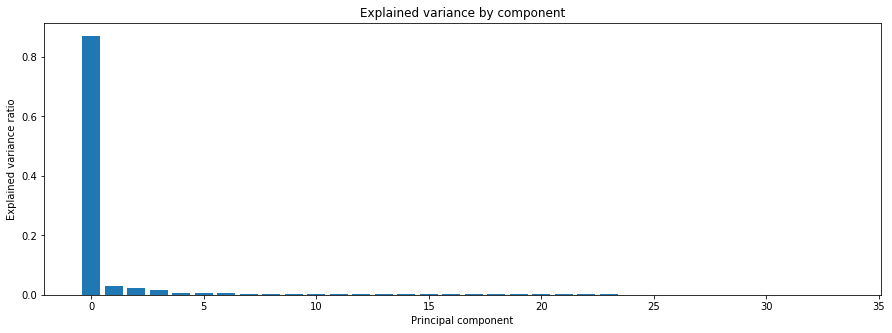

In [38]:
# Investigate the variance accounted for by each principal component.
plot_variance_by_component(azdias_pca_all)

In [39]:
# this function is taken from the classroom
def variance_cumulative(pca):
    plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
    plt.title("Explained Variance Cumulative")
    plt.xlabel("Component number")
    plt.ylabel("Explained variance ratio")
    plt.show()

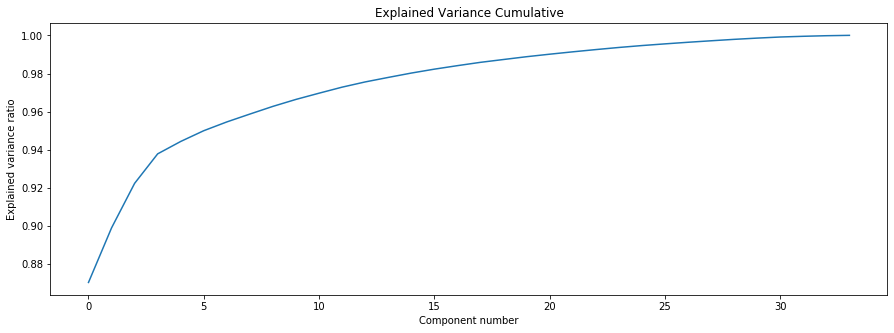

In [40]:
# Investigate the variance cumulative
variance_cumulative(azdias_pca_all)

In [42]:
# Re-run PCA to the data while selecting to retain 10 components.
azdias_pca_10, azdias_X_pca_10 = pca_op(10, azdias)

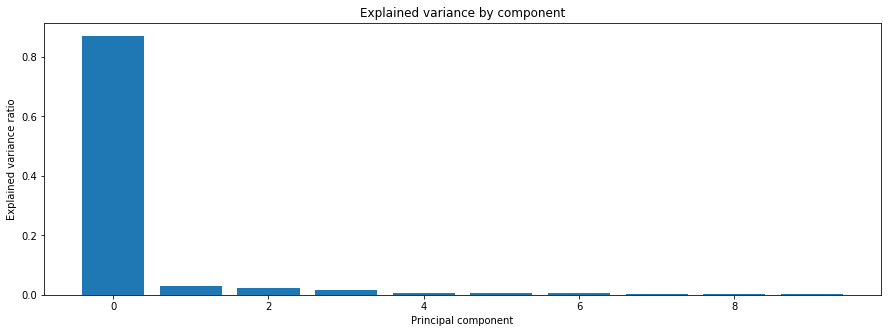

In [43]:
# Investigate the variance accounted for by each principal component when 10 components are used
plot_variance_by_component(azdias_pca_10)

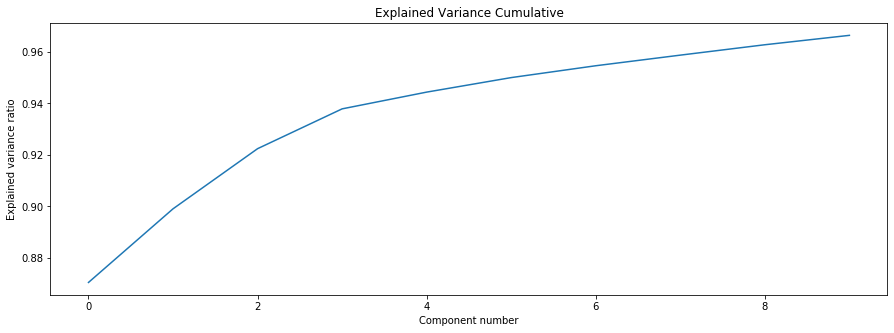

In [44]:
# Investigate the variance cumulative when 10 components are used
variance_cumulative(azdias_pca_10)

In [45]:
# this function is taken from the classroom
def get_weights(pca, component_num, data):
    df = pd.DataFrame(pca.components_, columns = list(azdias.columns))
    weights = df.iloc[component_num].sort_values(ascending=False)
    return weights

In [46]:
# print relationship between azdias features and pca components
dimensions = len(azdias_pca_10.components_)
result = pd.DataFrame()
for dim in range(dimensions):
    df = get_weights(azdias_pca_10, dim, azdias)
    result = pd.concat([result, df], axis = 1)
result = result.T
result

C:\Users\Reza\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
0,0.033897,0.000042,-0.018935,0.022566,-0.040405,0.003904,0.031136,-0.048476,-0.042502,0.044666,...,-0.019844,0.024810,-0.017050,-0.030735,-0.026213,-0.029492,-0.006453,-0.028857,0.003862,-0.014257
1,-0.089035,-0.349019,0.040201,0.040698,-0.043393,-0.109310,0.101935,0.035230,0.036722,-0.041759,...,0.321860,-0.057094,0.144501,0.078873,-0.066024,0.211403,0.274219,0.080500,0.319649,-0.051420
2,-0.253022,0.090742,0.095892,-0.151071,0.182214,0.180479,-0.291707,0.225938,0.157525,-0.185784,...,0.106294,-0.176844,0.172124,0.269457,0.264706,0.230285,-0.005871,0.241419,-0.125390,0.185906
3,-0.178083,0.140486,0.124591,-0.050090,0.120012,-0.265889,0.131633,0.062681,0.134971,-0.110933,...,-0.000499,-0.118832,0.053207,0.165058,0.221299,0.088719,-0.090290,0.199536,-0.108922,-0.172188
4,-0.065347,0.013244,-0.131940,0.120244,-0.105035,-0.281260,0.221844,-0.078097,0.002129,-0.015631,...,0.026847,-0.068477,0.119667,0.074576,0.113985,0.046758,-0.053415,0.134155,-0.031166,-0.008264
5,-0.090137,0.004246,-0.021188,0.529584,-0.126407,-0.086670,0.152363,-0.194068,-0.393904,0.139741,...,0.082250,-0.150669,0.210907,0.108153,0.162937,0.038237,-0.063472,0.160700,-0.046595,0.228667
6,-0.066587,0.059105,-0.506688,-0.295571,-0.179414,0.285530,-0.079194,-0.113566,0.031373,0.181874,...,-0.003881,0.110734,0.217843,0.039198,0.172365,0.088611,-0.018320,0.166072,-0.022594,-0.176511
7,0.006231,-0.022057,-0.108426,0.060041,0.217225,-0.209154,0.034701,0.117510,0.071352,-0.158646,...,0.025515,-0.131638,-0.150379,-0.012389,-0.069742,-0.017828,-0.024214,-0.072901,-0.004860,0.126098
8,-0.148573,0.011658,-0.561833,-0.010989,0.149994,-0.053170,0.026045,0.023378,-0.036643,0.000641,...,0.000654,-0.456864,-0.393339,-0.021794,-0.065913,-0.036478,0.047057,-0.015647,-0.027580,-0.066004
9,0.216501,-0.016052,-0.317868,0.009147,0.236314,-0.234159,0.059687,0.156727,0.135503,-0.257823,...,0.005639,0.414668,0.390494,-0.045873,0.040481,0.018538,-0.186169,0.003011,0.032761,0.059346


In [47]:
def plot_weights_by_component(idx, pca_data):
    df = pd.DataFrame(pca_data.loc[idx].sort_values().reset_index())
    print(df)
    plt.rcParams["figure.figsize"] = [16,6]
    #plt.bar(result.loc[0].sort_values().index.tolist(), result.loc[0].sort_values().values.tolist())
    plt.bar(df.index.tolist(), result.loc[idx].sort_values().values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()
    
    plt.rcParams["figure.figsize"] = [16,6]
    plt.bar(result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()

                    index         0
0             GEBURTSJAHR -0.990859
1           FINANZ_SPARER -0.048476
2   FINANZ_UNAUFFAELLIGER -0.042502
3          FINANZ_ANLEGER -0.040405
4           SEMIO_PFLICHT -0.030735
5               SEMIO_REL -0.029492
6             SEMIO_TRADV -0.028857
7               SEMIO_RAT -0.026213
8       ONLINE_AFFINITAET -0.021111
9              SEMIO_KULT -0.019844
10          CJT_GESAMTTYP -0.018935
11              SEMIO_MAT -0.017050
12              SEMIO_FAM -0.016148
13               ZABEOTYP -0.014257
14        GFK_URLAUBERTYP -0.008476
15     HH_EINKOMMEN_SCORE -0.006675
16              SEMIO_SOZ -0.006453
17        LP_FAMILIE_FEIN -0.005733
18              SEMIO_DOM -0.001967
19              ANREDE_KZ  0.000042
20             SEMIO_KAEM  0.001441
21    LP_LEBENSPHASE_FEIN  0.003245
22             SEMIO_VERT  0.003862
23       FINANZ_HAUSBAUER  0.003904
24       GREEN_AVANTGARDE  0.004490
25             SEMIO_KRIT  0.005327
26         LP_STATUS_FEIN  0

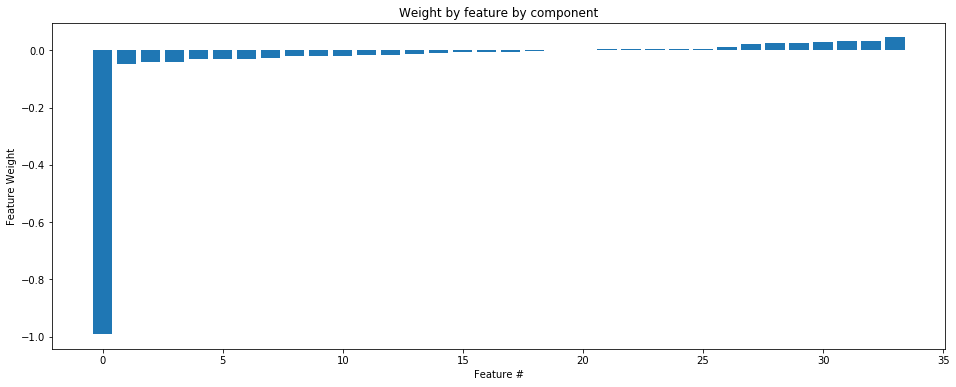

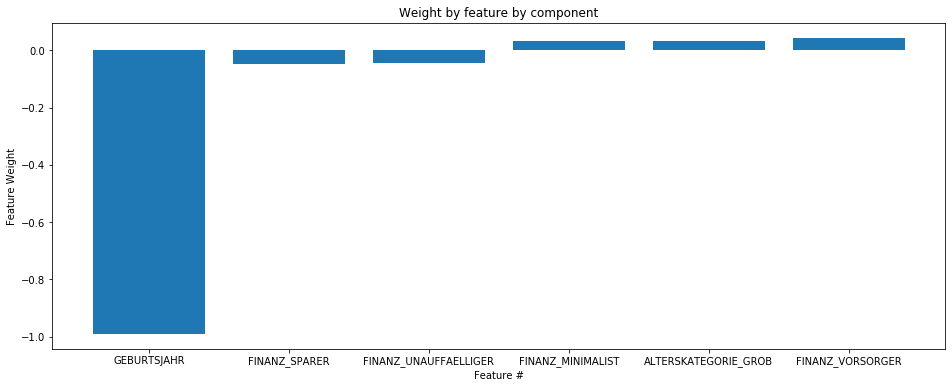

                    index         1
0               ANREDE_KZ -0.349019
1              SEMIO_KAEM -0.336510
2               SEMIO_DOM -0.290322
3              SEMIO_KRIT -0.290145
4               SEMIO_ERL -0.277008
5        FINANZ_HAUSBAUER -0.109310
6    ALTERSKATEGORIE_GROB -0.089035
7               SEMIO_RAT -0.066024
8              SEMIO_LUST -0.057094
9      HH_EINKOMMEN_SCORE -0.052228
10               ZABEOTYP -0.051420
11         FINANZ_ANLEGER -0.043393
12       FINANZ_VORSORGER -0.041759
13            GEBURTSJAHR -0.036328
14        GFK_URLAUBERTYP -0.001639
15         RETOURTYP_BK_S  0.001109
16        LP_FAMILIE_FEIN  0.031523
17    LP_LEBENSPHASE_FEIN  0.034864
18          FINANZ_SPARER  0.035230
19  FINANZ_UNAUFFAELLIGER  0.036722
20          CJT_GESAMTTYP  0.040201
21              FINANZTYP  0.040698
22       GREEN_AVANTGARDE  0.045907
23      ONLINE_AFFINITAET  0.053408
24         LP_STATUS_FEIN  0.053574
25          SEMIO_PFLICHT  0.078873
26            SEMIO_TRADV  0

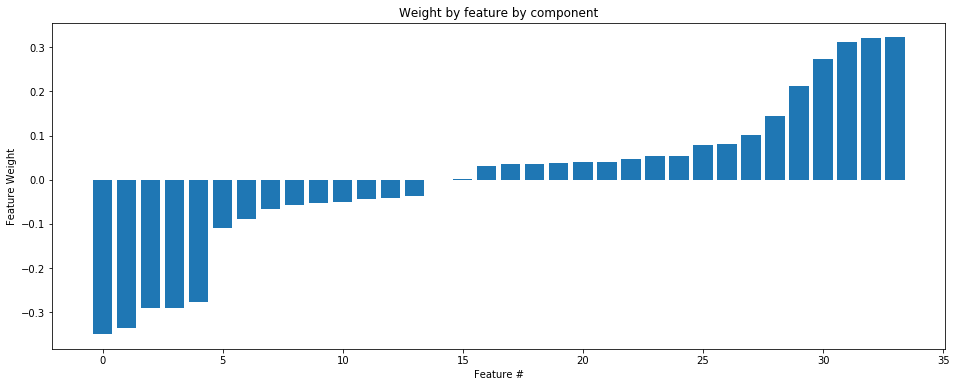

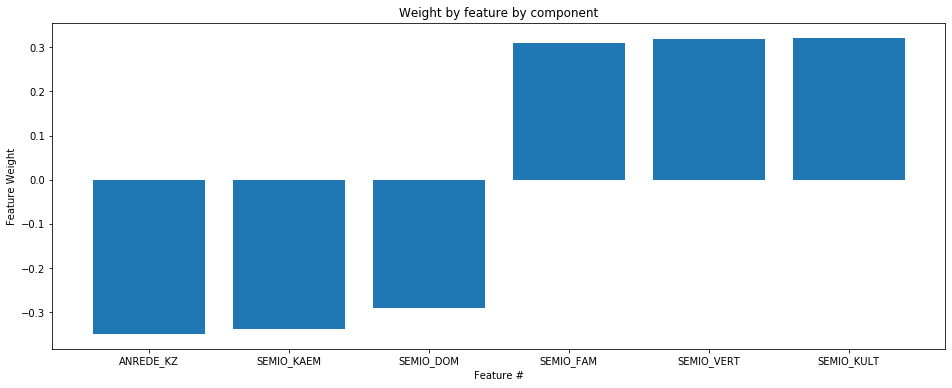

                    index         2
0       FINANZ_MINIMALIST -0.291707
1    ALTERSKATEGORIE_GROB -0.253022
2          LP_STATUS_FEIN -0.237536
3     LP_LEBENSPHASE_FEIN -0.194371
4        FINANZ_VORSORGER -0.185784
5              SEMIO_LUST -0.176844
6        GREEN_AVANTGARDE -0.168448
7               FINANZTYP -0.151071
8               SEMIO_ERL -0.131498
9              SEMIO_VERT -0.125390
10        LP_FAMILIE_FEIN -0.120443
11            GEBURTSJAHR -0.109689
12         RETOURTYP_BK_S -0.074512
13      ONLINE_AFFINITAET -0.026725
14              SEMIO_SOZ -0.005871
15             SEMIO_KRIT  0.048117
16              SEMIO_DOM  0.082245
17             SEMIO_KAEM  0.089508
18              ANREDE_KZ  0.090742
19              SEMIO_FAM  0.094271
20          CJT_GESAMTTYP  0.095892
21        GFK_URLAUBERTYP  0.102857
22             SEMIO_KULT  0.106294
23  FINANZ_UNAUFFAELLIGER  0.157525
24              SEMIO_MAT  0.172124
25       FINANZ_HAUSBAUER  0.180479
26         FINANZ_ANLEGER  0

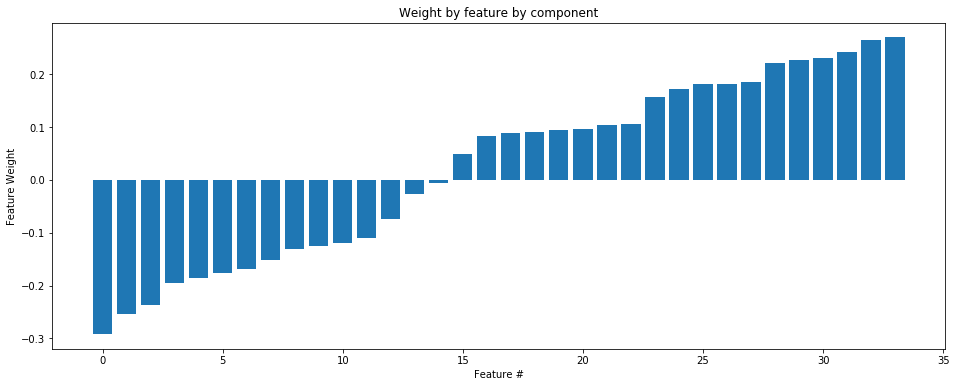

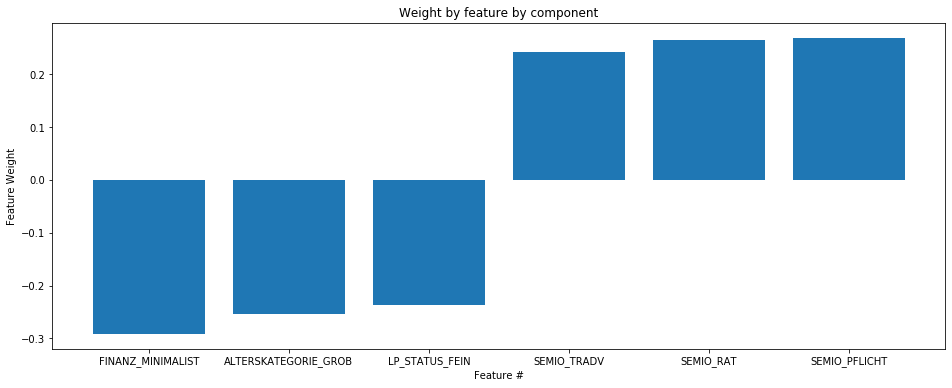

                    index         3
0      HH_EINKOMMEN_SCORE -0.319756
1        FINANZ_HAUSBAUER -0.265889
2    ALTERSKATEGORIE_GROB -0.178083
3                ZABEOTYP -0.172188
4          RETOURTYP_BK_S -0.159028
5              SEMIO_LUST -0.118832
6        FINANZ_VORSORGER -0.110933
7              SEMIO_VERT -0.108922
8               SEMIO_SOZ -0.090290
9               SEMIO_FAM -0.061505
10            GEBURTSJAHR -0.050927
11              FINANZTYP -0.050090
12        GFK_URLAUBERTYP -0.049975
13              SEMIO_ERL -0.040116
14             SEMIO_KULT -0.000499
15             SEMIO_KRIT  0.030193
16              SEMIO_MAT  0.053207
17          FINANZ_SPARER  0.062681
18              SEMIO_REL  0.088719
19             SEMIO_KAEM  0.111664
20         FINANZ_ANLEGER  0.120012
21          CJT_GESAMTTYP  0.124591
22      FINANZ_MINIMALIST  0.131633
23  FINANZ_UNAUFFAELLIGER  0.134971
24              ANREDE_KZ  0.140486
25              SEMIO_DOM  0.150339
26          SEMIO_PFLICHT  0

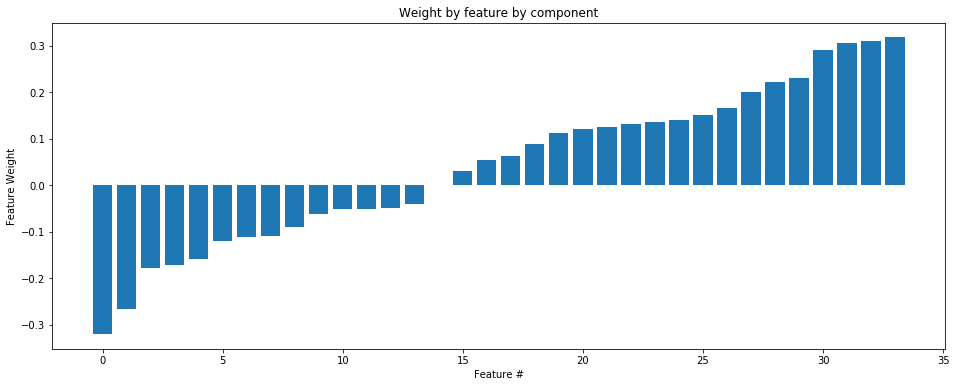

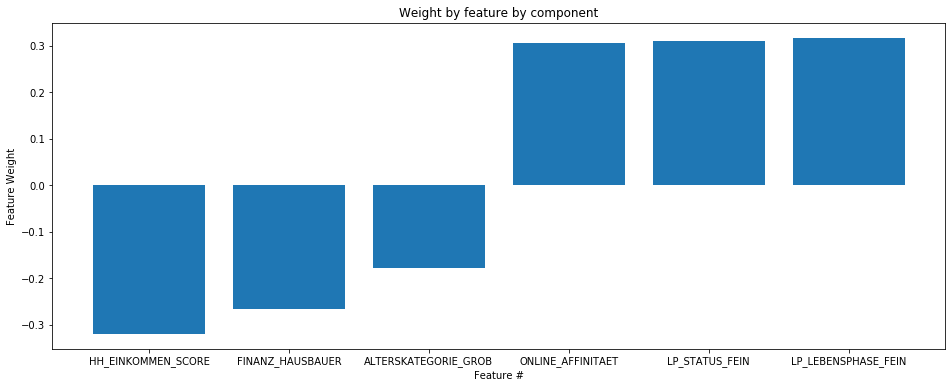

                    index         4
0         LP_FAMILIE_FEIN -0.556131
1     LP_LEBENSPHASE_FEIN -0.443135
2        FINANZ_HAUSBAUER -0.281260
3       ONLINE_AFFINITAET -0.236529
4      HH_EINKOMMEN_SCORE -0.222657
5           CJT_GESAMTTYP -0.131940
6          FINANZ_ANLEGER -0.105035
7           FINANZ_SPARER -0.078097
8              SEMIO_LUST -0.068477
9    ALTERSKATEGORIE_GROB -0.065347
10        GFK_URLAUBERTYP -0.058596
11              SEMIO_SOZ -0.053415
12              SEMIO_ERL -0.044110
13             SEMIO_VERT -0.031166
14       FINANZ_VORSORGER -0.015631
15               ZABEOTYP -0.008264
16  FINANZ_UNAUFFAELLIGER  0.002129
17              SEMIO_FAM  0.007949
18              ANREDE_KZ  0.013244
19            GEBURTSJAHR  0.016155
20             SEMIO_KULT  0.026847
21             SEMIO_KAEM  0.031417
22              SEMIO_REL  0.046758
23          SEMIO_PFLICHT  0.074576
24         RETOURTYP_BK_S  0.094587
25              SEMIO_DOM  0.103690
26              SEMIO_RAT  0

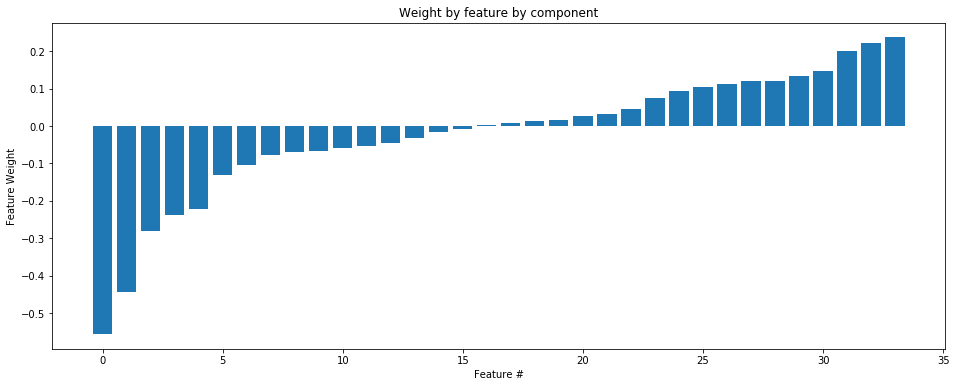

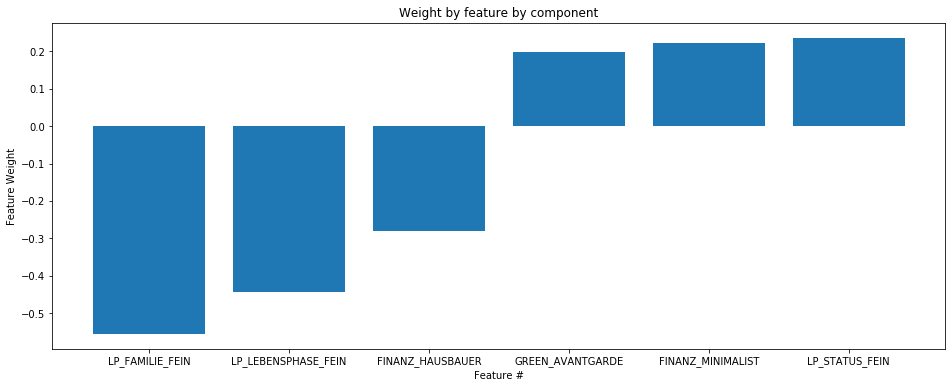

In [48]:
for i in range(5):
    plot_weights_by_component(i, result)

In [49]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)
        print(score_list)

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

1
3.2951903343200684
[162135508.39909592]
2
6.72470760345459
[162135508.39909592, 84042168.8767872]
3
9.508561372756958
[162135508.39909592, 84042168.8767872, 38985027.04033363]
4
15.504176139831543
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534]
5
21.226578950881958
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534, 25507155.096103538]
6
29.026341438293457
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534, 25507155.096103538, 23191873.60702603]
7
32.159857511520386
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534, 25507155.096103538, 23191873.60702603, 21179190.822780274]
8
32.57937002182007
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534, 25507155.096103538, 23191873.60702603, 21179190.822780274, 19206050.480300263]
9
55.941012144088745
[162135508.39909592, 84042168.8767872, 38985027.04033363, 31665938.31168534, 25507155.096103538, 23191873.60702603,

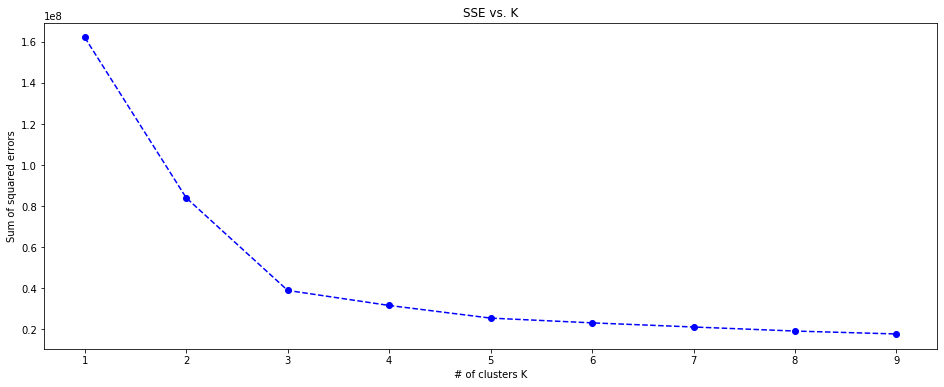

In [50]:
elbow_plot(azdias_X_pca_10, 1, 10, 1)

In [51]:
# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
azdias_kmeans = KMeans(5)
azdias_model = azdias_kmeans.fit(azdias_X_pca_10)
azdias_labels = azdias_model.predict(azdias_X_pca_10)

In [52]:
# view first few labels predicted for the azdias dataset
azdias_labels[0:10]

array([4, 2, 3, 0, 1, 0, 0, 0, 2, 1])

In [53]:
# Perform PCA on customers dataset
customers_pca_10 = azdias_pca_10.transform(customers)

In [54]:
# predict and print first few labels for the customers dataset
customers_labels = azdias_model.predict(customers_pca_10)
customers_labels[0:10]

array([1, 1, 1, 3, 1, 1, 1, 1, 3, 3])

### Compare Customer Data to Demographics Data

In [55]:
def calc_propotions(labels, population):
    counter = Counter(labels)
    proportions = [(i, counter[i] / population * 100.0) for i in counter]
    proportions.sort(key=itemgetter(0))
    proportions = np.array(proportions)
    
    dropped_gen_pop = 100 - round(proportions[:, 1].sum())
    if (dropped_gen_pop > 1):
        proportions = np.insert(proportions, 0, values=[dropped_gen_pop], axis=0)
    
    return proportions

In [56]:
customers.shape, azdias.shape

((188439, 34), (737288, 34))

In [57]:
# for azdias calculated the proportions of each cluster
general_population = 737288
azdias_proportions = calc_propotions(azdias_labels, general_population)
print(azdias_proportions)

[[ 0.         55.26402166]
 [ 1.          8.18730266]
 [ 2.         15.02804874]
 [ 3.         13.49798179]
 [ 4.          8.02264515]]


In [58]:
# for customers calculated the proportions of each cluster
general_population = 188439 #191652 #132907#
customers_proportions = calc_propotions(customers_labels, general_population)
print(customers_proportions)

[[ 0.          9.31654275]
 [ 1.         71.48520211]
 [ 2.          2.53981395]
 [ 3.         16.02056899]
 [ 4.          0.6378722 ]]


In [59]:
# calculate the ration between general population (azdias) and customers
# to see which customer segments are under and over represented
representation_ratio = customers_proportions[0:, 1]/azdias_proportions[0:, 1]
representation_ratio

array([0.16858242, 8.7312275 , 0.1690049 , 1.18688625, 0.07950896])

Text(0.5, 1.0, 'Customer Population/General Population')

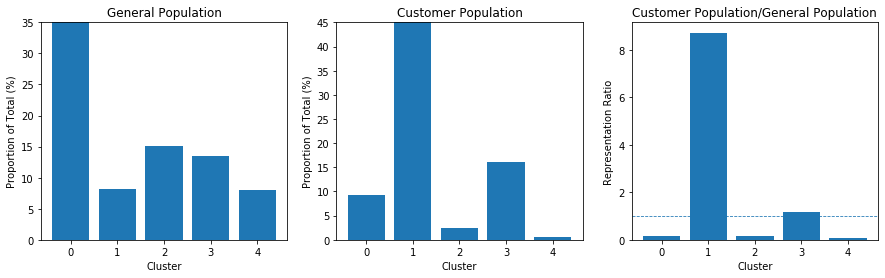

In [60]:
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(131)
ax1.bar(azdias_proportions[:, 0], azdias_proportions[:, 1])
ax1.set_xticks(azdias_proportions[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(customers_proportions[:, 0], customers_proportions[:, 1])
ax2.set_xticks(azdias_proportions[:, 0])
ax2.set_ylim(ymax = 45)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customer Population')

ax3 = plt.subplot(133)
ax3.bar(azdias_proportions[:, 0], representation_ratio)
ax3.set_xticks(azdias_proportions[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Representation Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 0.8)
plt.title('Customer Population/General Population')

In [61]:
tt = azdias_pca_10.inverse_transform(azdias_model.cluster_centers_[2])
c_2 = tt
underpresented = pd.Series(data = c_2, index = customers.columns).sort_values()
underpresented

FINANZ_VORSORGER           -0.994898
RETOURTYP_BK_S             -0.651156
ALTERSKATEGORIE_GROB       -0.619638
FINANZ_MINIMALIST          -0.539310
FINANZTYP                  -0.435250
SEMIO_ERL                  -0.391044
SEMIO_LUST                 -0.385069
FINANZ_HAUSBAUER           -0.242280
GREEN_AVANTGARDE           -0.165935
LP_LEBENSPHASE_FEIN        -0.165698
SEMIO_VERT                 -0.109981
LP_STATUS_FEIN             -0.080171
SEMIO_KRIT                 -0.036842
LP_FAMILIE_FEIN            -0.003818
SEMIO_KAEM                  0.001565
ANREDE_KZ                   0.038646
SEMIO_SOZ                   0.043705
SEMIO_DOM                   0.049250
HH_EINKOMMEN_SCORE          0.108391
GFK_URLAUBERTYP             0.217116
ZABEOTYP                    0.297889
SEMIO_FAM                   0.319285
SEMIO_KULT                  0.391173
SEMIO_MAT                   0.427450
ONLINE_AFFINITAET           0.458525
CJT_GESAMTTYP               0.493976
SEMIO_RAT                   0.556437
S

In [62]:
tt = azdias_pca_10.inverse_transform(azdias_model.cluster_centers_[4])
c_4 = tt
underpresented = pd.Series(data = c_4, index = customers.columns).sort_values()
underpresented

FINANZ_MINIMALIST          -1.096075
FINANZTYP                  -1.086337
FINANZ_VORSORGER           -1.076182
ALTERSKATEGORIE_GROB       -0.951842
RETOURTYP_BK_S             -0.895656
SEMIO_ERL                  -0.715620
SEMIO_LUST                 -0.698352
LP_STATUS_FEIN             -0.467875
SEMIO_KRIT                 -0.325965
SEMIO_VERT                 -0.084702
SEMIO_KAEM                 -0.062000
SEMIO_DOM                  -0.041387
ANREDE_KZ                   0.026905
GREEN_AVANTGARDE            0.066716
ZABEOTYP                    0.131134
HH_EINKOMMEN_SCORE          0.143083
LP_LEBENSPHASE_FEIN         0.172285
SEMIO_MAT                   0.193837
GFK_URLAUBERTYP             0.234969
SEMIO_SOZ                   0.299595
FINANZ_HAUSBAUER            0.321587
CJT_GESAMTTYP               0.386649
SEMIO_FAM                   0.394254
SEMIO_KULT                  0.463357
LP_FAMILIE_FEIN             0.491644
SEMIO_RAT                   0.611929
ONLINE_AFFINITAET           0.675891
S

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [141]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')

C:\Users\Reza\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
mailout_train.shape

(42962, 367)

In [143]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()
# Positive response
pos_res = vc[1]/(vc[0]+vc[1])
# Negative response
neg_res = 1 - pos_res
print("Ratio of postive response: {0: 0.3f} and negative response: {1: 0.3f}".format(pos_res, neg_res))

Ratio of postive response:  0.012 and negative response:  0.988


In [144]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

In [145]:
# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [146]:
mailout_train = clean_data(mailout_train, attributes, 0.2, 1)
mailout_train.shape

(42962, 177)

In [147]:
unique_mailout_feature = set(mailout_train.columns.tolist()) - set(azdias.columns.tolist())
mailout_train.drop(columns=list(unique_mailout_feature), inplace=True)

In [148]:
mailout_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Data columns (total 34 columns):
CJT_GESAMTTYP            42357 non-null float64
FINANZ_ANLEGER           42962 non-null float64
FINANZ_HAUSBAUER         42962 non-null float64
FINANZ_MINIMALIST        42962 non-null float64
FINANZ_SPARER            42962 non-null float64
FINANZ_UNAUFFAELLIGER    42962 non-null float64
FINANZ_VORSORGER         42962 non-null float64
FINANZTYP                42962 non-null float64
GEBURTSJAHR              42962 non-null int64
GFK_URLAUBERTYP          42357 non-null float64
GREEN_AVANTGARDE         42962 non-null int64
HH_EINKOMMEN_SCORE       42258 non-null float64
LP_FAMILIE_FEIN          42357 non-null float64
LP_LEBENSPHASE_FEIN      42357 non-null float64
LP_STATUS_FEIN           42357 non-null float64
ONLINE_AFFINITAET        42357 non-null float64
RETOURTYP_BK_S           42357 non-null float64
SEMIO_DOM                42962 non-null float64
SEMIO_ERL                42962 

In [149]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
mailout_train["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
mailout_train_year = mailout_train.loc[:, ["GEBURTSJAHR"]]
mailout_train.drop(columns=["GEBURTSJAHR"], inplace=True)

In [150]:
mailout_train.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,2.0,5.0,3.0,1.0,1.0,5.0,6.0,8.0,0,...,1.0,3.0,2.0,1.0,5.0,1.0,3.0,3.0,2.0,4.0
1,2.0,2.0,3.0,5.0,1.0,1.0,5.0,6.0,8.0,0,...,5.0,5.0,4.0,3.0,1.0,3.0,4.0,1.0,2.0,3.0
2,4.0,1.0,2.0,5.0,1.0,1.0,4.0,5.0,3.0,1,...,6.0,1.0,1.0,5.0,3.0,1.0,7.0,3.0,1.0,4.0
3,2.0,1.0,5.0,4.0,1.0,2.0,5.0,5.0,5.0,1,...,1.0,4.0,2.0,2.0,5.0,3.0,2.0,3.0,2.0,4.0
4,6.0,1.0,5.0,3.0,1.0,1.0,5.0,5.0,4.0,0,...,6.0,4.0,5.0,4.0,6.0,2.0,7.0,3.0,1.0,3.0


In [151]:
mailout_train_year.head()

,GEBURTSJAHR
0,NaN
1,1957.0
2,1929.0
3,1924.0
4,1936.0


In [152]:
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mailout_train = pd.DataFrame(imputer_numeric.fit_transform(mailout_train), columns = mailout_train.columns)
mailout_train_year = pd.DataFrame(imputer_numeric.fit_transform(mailout_train_year), columns = mailout_train_year.columns)

scaler = StandardScaler()
mailout_train_scale = scaler.fit_transform(mailout_train)

mailout_train = pd.DataFrame(mailout_train_scale, columns=mailout_train.columns)
mailout_train = pd.concat([mailout_train, mailout_train_year], axis=1)
mailout_train.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,GEBURTSJAHR
0,-0.732206,-0.240815,1.385118,-0.681520,-0.695142,-0.83965,0.752040,1.036622,0.502041,-0.623381,...,-0.220122,-0.935340,-1.179179,0.819551,-1.333690,-0.421575,0.174577,0.824885,0.736410,1941.0
1,-0.732206,-0.240815,-0.172913,1.152976,-0.695142,-0.83965,0.752040,1.036622,0.502041,-0.623381,...,1.053277,0.628425,-0.225069,-1.564344,0.160176,0.053910,-1.608634,0.824885,-0.200391,1957.0
2,0.397980,-0.888123,-0.951928,1.152976,-0.695142,-0.83965,-0.263524,0.437255,-1.163880,1.604156,...,-1.493521,-1.717223,0.729041,-0.372397,-1.333690,1.480366,0.174577,-1.212290,0.736410,1929.0
3,-0.732206,-0.888123,1.385118,0.235728,-0.695142,-0.17189,0.752040,0.437255,-0.497512,1.604156,...,0.416577,-0.935340,-0.702124,0.819551,0.160176,-0.897061,0.174577,0.824885,0.736410,1924.0
4,1.528167,-0.888123,1.385118,-0.681520,-0.695142,-0.83965,0.752040,0.437255,-0.830696,-0.623381,...,0.416577,1.410308,0.251986,1.415524,-0.586757,1.480366,0.174577,-1.212290,-0.200391,1936.0


In [153]:
def classify(clf, param_grid, X_train=mailout_train, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [154]:
# LogisticRegression
lor = LogisticRegression(random_state=0)
classify(lor, {})

C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

0.5480353390728977


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
# BaggingClassifier
bac = BaggingClassifier(random_state=0)
classify(bac, {})

0.5017386718359778


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)

In [156]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
classify(rfc, {})

C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Reza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: Future

0.5066155094352407


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [157]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=0)
abc_best_est = classify(abc, {})

0.549784848650356


In [158]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0)
classify(gbc, {})

0.5263932172866405


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model Tuning

In [160]:
# tune the most promising classifier with the help of GridSearchCV
# the result is our model that will be used with the test set
abc = AdaBoostClassifier(random_state=0)
param_grid = {"algorithm" :["SAMME", "SAMME.R"],
              'n_estimators':[80]
             }

abc_best_est = classify(abc, param_grid)
abc_best_est

0.5526534122045542


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=80, random_state=0)

In [161]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':abc_best_est.feature_importances_}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
GEBURTSJAHR,0.2750
SEMIO_PFLICHT,0.0625
LP_LEBENSPHASE_FEIN,0.0625
SEMIO_TRADV,0.0375
GFK_URLAUBERTYP,0.0375
LP_FAMILIE_FEIN,0.0375
LP_STATUS_FEIN,0.0375
SEMIO_DOM,0.0250
ZABEOTYP,0.0250
SEMIO_SOZ,0.0250


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [163]:
mailout_test = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv")
mailout_test.head()

C:\Users\Reza\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [164]:
# extract lnr for later generation of the competition result file
lnr = mailout_test.LNR

In [165]:
# clean data
mailout_test = clean_data(mailout_test, attributes, 0.2, 1)
mailout_test.shape

(42833, 179)

In [166]:
unique_mailout_test_feature = set(mailout_test.columns.tolist()) - set(azdias.columns.tolist())
mailout_test.drop(columns=list(unique_mailout_test_feature), inplace=True)
mailout_test.shape

(42833, 34)

In [167]:
# Fill missing values (0) at "GEBURTSJAHR" with NaN
mailout_test["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

# Create subset of "GEBURTSJAHR" for different imputation strategy
mailout_test_year = mailout_test.loc[:, ["GEBURTSJAHR"]]
mailout_test.drop(columns=["GEBURTSJAHR"], inplace=True)

In [168]:
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mailout_test = pd.DataFrame(imputer_numeric.fit_transform(mailout_test), columns = mailout_test.columns)
mailout_test_year = pd.DataFrame(imputer_numeric.fit_transform(mailout_test_year), columns = mailout_test_year.columns)

scaler = StandardScaler()
mailout_test_scale = scaler.fit_transform(mailout_test)

mailout_test = pd.DataFrame(mailout_test_scale, columns=mailout_test.columns)
mailout_test = pd.concat([mailout_test, mailout_test_year], axis=1)
mailout_test.head()

,CJT_GESAMTTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,...,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,GEBURTSJAHR
0,0.968505,-0.890040,-0.170334,1.153595,-0.695186,-0.165701,0.748690,0.428851,1.168926,1.600254,...,-1.490175,-1.712756,-0.698413,1.417435,-1.348584,1.487462,0.178441,-1.213276,0.728696,1941.0
1,-1.310239,-0.890040,1.381826,-0.676070,-0.695186,-0.834075,0.748690,1.027034,1.168926,-0.624901,...,-0.216722,-0.148774,-0.221305,1.417435,-1.348584,1.009979,0.178441,-1.213276,0.728696,1941.0
2,-0.740553,-0.890040,0.605746,0.238763,-0.695186,-0.165701,0.748690,-1.365696,-0.488426,1.600254,...,0.420005,-0.148774,-1.175520,0.228022,0.153084,-0.422470,0.178441,0.824215,0.728696,1946.0
3,0.398819,-0.242855,0.605746,0.238763,-0.695186,-0.834075,-0.265595,1.027034,-0.156956,-0.624901,...,-0.853448,-0.148774,-0.698413,-0.366684,0.153084,-0.899952,0.178441,0.824215,0.728696,1941.0
4,1.538191,0.404330,-0.946415,1.153595,-0.695186,-0.834075,0.748690,1.027034,1.168926,-0.624901,...,-0.216722,-0.148774,-0.698413,0.822728,0.153084,-0.422470,1.070811,0.824215,0.728696,1956.0


In [169]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = abc_best_est.predict_proba(mailout_test)
response_test

array([[0.51381146, 0.48618854],
       [0.51451578, 0.48548422],
       [0.51413036, 0.48586964],
       ...,
       [0.5139348 , 0.4860652 ],
       [0.51253005, 0.48746995],
       [0.51429738, 0.48570262]])

In [170]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv("result.csv", index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.513811
1,1770,0.514516
2,1465,0.514130
3,1470,0.517181
4,1478,0.516291
5,1782,0.512124
6,1485,0.513568
7,1519,0.517869
8,1835,0.512794
9,1522,0.514271
